# Centinela project: Fin Identification




## Requirements:
- Create a short cut of the data folder into your drive and edit the ds_path link

## Imports

In [ ]:
import os
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import top_k_accuracy_score
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import random

!pip install imgaug
import imgaug
import imgaug.augmenters as iaa
imgaug.seed(100)
np.random.seed(100)
random.seed(10)
tf.random.set_seed(100)

CUSTOMIZE THIS PATH

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/Centinela_project/datasets/dataset_classification.zip'

Archive:  /content/drive/MyDrive/Centinela_project/datasets/dataset_classification.zip
replace dataset_classification/AURO_0_jpg.rf.0d5262ea6d31dcb891155132d9e5c33b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
ds_path = 'dataset_classification'

## Data loading

Loading data into a dataframe

In [ ]:
def create_df(ds_path):
  imgs = []
  labels = []
  for file in os.listdir(ds_path):
    imgs.append(os.path.join(ds_path, file))
    label = file.split('_jpg')[0].split('_')[0]
    labels.append(label)

  df = pd.DataFrame(list(zip(labels, imgs)), columns=['whale_id','images'])
  return df

In [ ]:
df = create_df(ds_path=ds_path)
df.head()

,whale_id,images
0,MARK,dataset_classification/MARK_25_jpg.rf.cb210a6b...
1,MARK,dataset_classification/MARK_144_jpg.rf.478f72e...
2,MARK,dataset_classification/MARK_135_jpg.rf.c12d2e1...
3,AURO,dataset_classification/AURO_8_jpg.rf.db13357cf...
4,ERNEST,dataset_classification/ERNEST_33_jpg.rf.f6485b...


## Dataset distribution

We got a total of  10 whales


<Axes: xlabel='whale_id'>

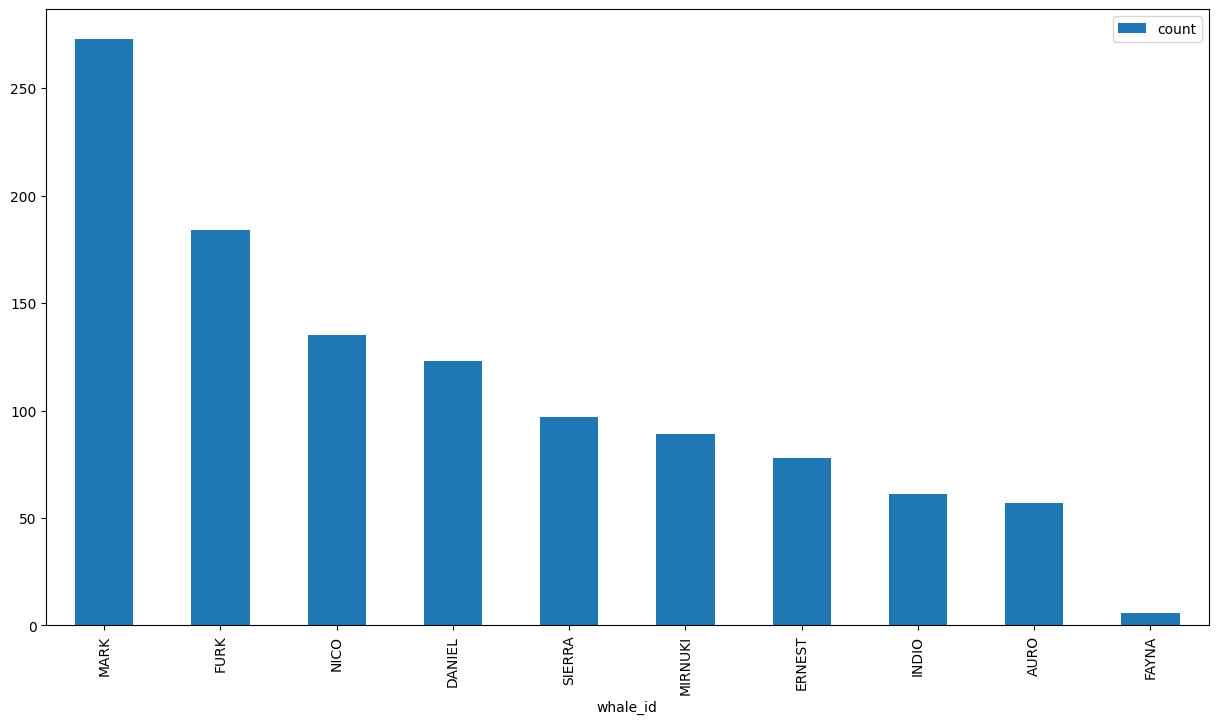

In [ ]:
filtered_count_df = df['whale_id'].value_counts().to_frame()
print("We got a total of ", len(filtered_count_df), "whales")
filtered_count_df.plot(kind='bar', figsize=(15,8))

## Data preprocessing

We are going to have to datasets, one with Fayna which will be used for standard classification during iference, and one without Fayna which will be used to train a classificator, but on inference we will use the model as an embedding function and create prototypes per class (mean of k samples) and classify each test sample based in closest distance (similarity) to prototypes.

### Creating dataset without Fayna

In [ ]:
df_dev = df[df['whale_id'] != 'FAYNA']

### Encoding labels



In [ ]:
# Encoding labels for standard ds
encoder = LabelEncoder()
df_dev['label'] = encoder.fit_transform(df_dev['whale_id'])
num_classes = len(np.unique(df_dev['label'].values))
print("Num classes standard dataset", num_classes)

Num classes standard dataset 9


<ipython-input-27-c99fbf85c0c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dev['label'] = encoder.fit_transform(df_dev['whale_id'])


## Defining data pipeline

In [ ]:
IMG_TARGET_WIDTH = 224
IMG_TARGET_HEIGHT = 224

def data_loader(ds, batch_size=32, is_test=False):
  ds = ds.map(load_img)
  if not is_test:
    ds = ds.map(lambda img, label: tf.py_function(func=augment_data, inp=[img, label], Tout=[tf.float32, tf.int64]))
    ds = ds.map(fix_shape)
    ds = ds.shuffle(len(ds)).repeat()

  ds = ds.batch(batch_size)

  return ds

def load_img(img, label):
  image = tf.io.read_file(img)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.resize(image, [IMG_TARGET_WIDTH,IMG_TARGET_HEIGHT])
  image = image*255
  return  image, label

def augment_data(img, label):
  img = img.numpy()

  img = iaa.Fliplr(0.5).augment_image(img) #Horizontal flip
  img = iaa.Sometimes(0.25, iaa.Multiply((0.5, 1.5))).augment_image(img) #Changes brightness
  img = iaa.Sometimes(0.15, iaa.ChannelShuffle(p=0.35)).augment_image(img) #Inverts channels 0 and 1 with a prob of .35
  img = iaa.Sometimes(0.20, iaa.AdditiveGaussianNoise(scale=(0, 0.1*255))).augment_image(img) #Gaussian noise with mean 0, std 0.15*255
  img = iaa.Sometimes(0.15, iaa.Dropout(p=(0, 0.10))).augment_image(img) #Drops pixels
  img = iaa.Sometimes(0.20, iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True)).augment_image(img.astype(np.uint8)).astype(np.float32) # Hue and saturation (only works with uint8)
  img = iaa.Sometimes(0.25, iaa.LinearContrast((0.4, 1.6))).augment_image(img) #Contrast

  img_tensor = tf.constant(img, dtype=tf.float32)

  return img_tensor,label

def fix_shape(img, label): #Required because tf.py_function messes up with the shape of tensors
  img.set_shape([224,224,3])
  label.set_shape([])
  return img,label

### Testing augmentations

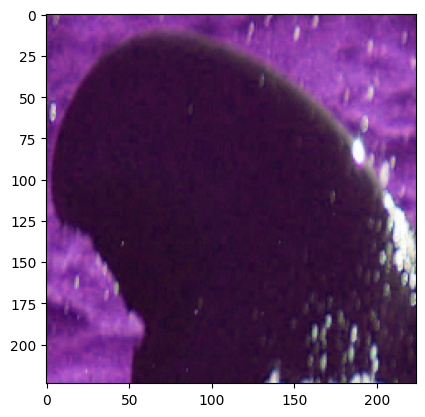

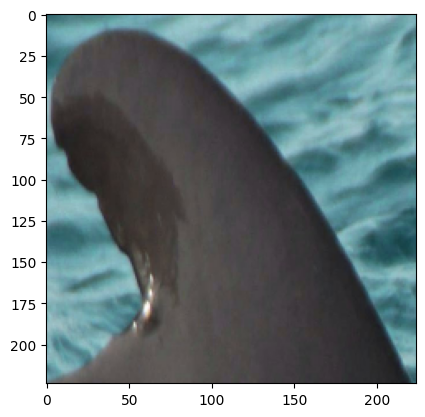

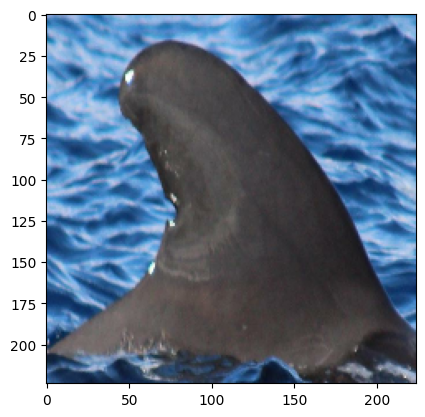

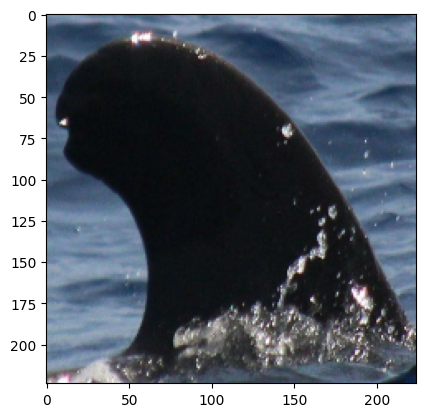

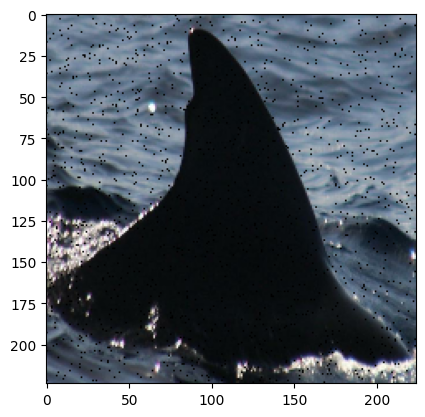

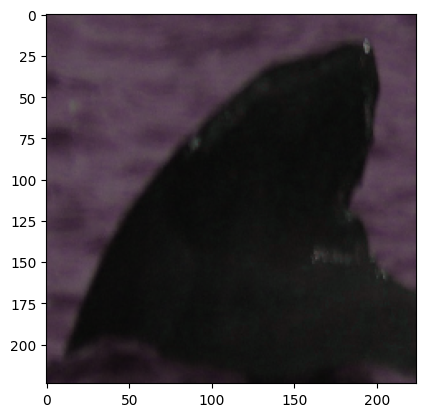

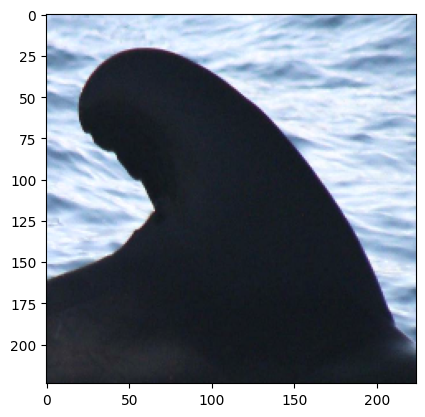

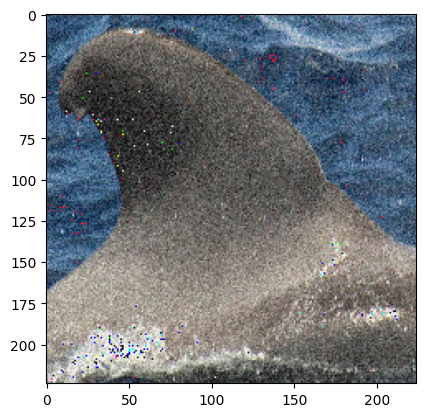

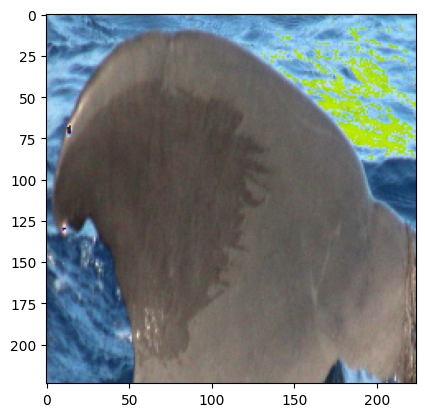

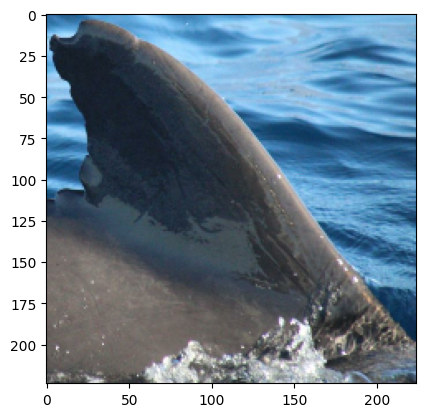

In [ ]:
example_ds = tf.data.Dataset.from_tensor_slices((df_dev['images'], df_dev['label']))
example_ds = data_loader(ds=example_ds, batch_size=10)

for img, label in example_ds.take(1):
  for image in img:
    plt.imshow(image/255)
    plt.show()

## Creating model
Defining model architecture for a classification task

In [ ]:
def create_efficient_net():
  inputs = tf.keras.layers.Input(shape=(224, 224, 3))
  base_model =  tf.keras.applications.efficientnet_v2.EfficientNetV2B0(input_tensor=inputs, include_top=False, weights='imagenet')
  base_model.trainable = False
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
  #x = tf.keras.layers.BatchNormalization()(x)
  for layer in base_model.layers[-3:]:
    layer.trainable = True

  top_dropout_rate = 0.2
  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")

  return model

## Training

### Defining evaluation function

In [ ]:
def evaluate_best_model(model_path, test_set, dest_folder=None):
  print('\n\n-------------------\nEvaluating best model standard classification\n-------------------')

  model = tf.keras.models.load_model(model_path)
  preds = []
  true_labels = []

  for images, labels in test_set.as_numpy_iterator():
    for image, label in zip(images,labels):
      pred = model.predict(np.expand_dims(image,0), verbose=0)
      pred = np.argmax(pred, axis=1)[0]
      preds.append(pred)
      true_labels.append(label)

  # Compute metrics
  acc = accuracy_score(true_labels, preds)
  prec = precision_score(true_labels, preds, average = "macro", zero_division = 0)
  rec = recall_score(true_labels, preds, average = "macro", zero_division = 0)
  f1 = f1_score(true_labels, preds, average = "macro", zero_division = 0)
  cm = confusion_matrix(true_labels, preds)

  print(f"\nAccuracy: {acc}\nPrecision: {prec}\nRecall: {rec}\nF1-Score: {f1}")

  # Saving results
  if dest_folder != None:
    print("Saving results...")
    with open(os.path.join(dest_folder,"metrics.txt"), "w") as file:
      file.write(f"accuracy: {acc}\n")
      file.write(f"precision: {prec}\n")
      file.write(f"recall: {rec}\n")
      file.write(f"f1_score: {f1}\n")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(np.unique(df_dev['whale_id'].values)))
    disp.plot(xticks_rotation='vertical').figure_.savefig(os.path.join(dest_folder,'confusion_matrix.png'))



### Training standard

#### Training configuration and hyperparameters

In [ ]:
# Hyperparameters
MODEL_NAME = 'EfficientNet_B0_v1'
TRAIN_BATCH_SIZE=32
TRAIN_STEPS=15
VAL_STEPS=1
EPOCHS=10

#### Data splitting and loading

In [ ]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(df_dev["images"], df_dev["label"], test_size=0.2, random_state=42)

# Create train ds
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = data_loader(train_ds, batch_size=TRAIN_BATCH_SIZE)

# Create val ds
validation_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_ds = data_loader(validation_ds, batch_size=len(y_val), is_test=True)

In [ ]:
for img_path in X_val[:50]:
    print(img_path)


dataset_classification/INDIO_16_jpg.rf.f3ea1379b0d16a3515601af9826acfa7.jpg
dataset_classification/DANIEL_60_jpg.rf.d74f6388dafdb2b5c7ed464720b1f088.jpg
dataset_classification/MARK_74_jpg.rf.560c1ae5edff1e2586e54dda792d64a4.jpg
dataset_classification/AURO_4_jpg.rf.f9bbb3b9925630168f08fd7369c251fd.jpg
dataset_classification/NICO_47_jpg.rf.e8988d8d7bb313cb0d97d0e33fd15331.jpg
dataset_classification/DANIEL_95_jpg.rf.d3da25045da67f1df35dec1525e4b82d.jpg
dataset_classification/SIERRA_25_jpg.rf.1180d56d2eb00b7af58acb02003b77a0.jpg
dataset_classification/FURK_128_jpg.rf.0f97cbec79384fe0c23a455d5ebb6090.jpg
dataset_classification/ERNEST_49_jpg.rf.637ee6b7997d4dc039254ddde97f34e2.jpg
dataset_classification/FURK_77_jpg.rf.6f51f58d3cc308725c8006d51befb4f1.jpg
dataset_classification/AURO_10_jpg.rf.799ffcfc5b310cece19e8f131b996975.jpg
dataset_classification/MARK_0_jpg.rf.b3d1c9938e88588361533f4c047e373b.jpg
dataset_classification/MARK_220_jpg.rf.570d8db0e317345e16f1c1e9779c4413.jpg
dataset_classifi

In [ ]:
!zip -r /content/runs/detect/train.zip /content/runs/detect/train
from google.colab import files
files.download("/content/runs/detect/train.zip")

#### Weight classes to counter data imbalance

In [ ]:
filtered_count_df_dev = df_dev['whale_id'].value_counts().to_frame()

In [ ]:
def weight_class(x):
    x = x.max()/x
    return x

weights_df = filtered_count_df_dev.apply(weight_class)

In [ ]:
weight_dict = {}
for index, row in weights_df.iterrows():
  label = df_dev.loc[df_dev['whale_id']==index]['label'].iloc[0]
  weight_dict[label] = row['count']

weight_dict

{5: 1.0,
 3: 1.483695652173913,
 7: 2.022222222222222,
 1: 2.2195121951219514,
 8: 2.814432989690722,
 6: 3.067415730337079,
 2: 3.5,
 4: 4.475409836065574,
 0: 4.7894736842105265}

#### Training loop

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.7219 - accuracy: 0.4703

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 25s 499ms/step - loss: 1.7219 - accuracy: 0.4703 - val_loss: 1.2687 - val_accuracy: 0.5982
Epoch 2/10
20/20 [==============================] - 7s 373ms/step - loss: 1.0629 - accuracy: 0.7000 - val_loss: 0.8144 - val_accuracy: 0.7580
Epoch 3/10
20/20 [==============================] - 9s 449ms/step - loss: 0.7718 - accuracy: 0.7984 - val_loss: 0.5931 - val_accuracy: 0.8676
Epoch 4/10
20/20 [==============================] - 6s 328ms/step - loss: 0.5696 - accuracy: 0.8734 - val_loss: 0.4601 - val_accuracy: 0.9041
Epoch 5/10
20/20 [==============================] - 6s 318ms/step - loss: 0.5027 - accuracy: 0.8797 - val_loss: 0.4012 - val_accuracy: 0.8950
Epoch 6/10
20/20 [==============================] - 8s 424ms/step - loss: 0.4539 - accuracy: 0.8844 - val_loss: 0.3373 - val_accuracy: 0.9178
Epoch 7/10
20/20 [==============================] - 8s 401ms/step - loss: 0.3244 - accuracy: 0.9266 - val_loss: 0.2928 - val_accuracy: 0.9406
Epoch 8/10
20/20

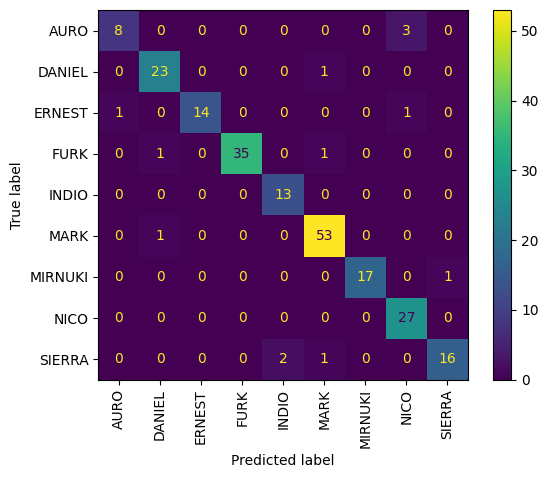

In [ ]:
# Initalize model
model = create_efficient_net()

folder_name = '/content/drive/MyDrive/Centinela_project/results/'+MODEL_NAME
if not os.path.exists(folder_name):
  os.makedirs(folder_name)
else:
  print(f"\n\n-------------------\nERROR!: FOLDER {MODEL_NAME} ALREADY EXISTS IN THE PATH. HALTING TRAINING....\n-------------------")
  sys.exit()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(folder_name,'saved_model.h5'), monitor='val_accuracy', mode='max', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
)

# Start training fold
history = model.fit(train_ds,
        validation_data = validation_ds,
        #class_weight = weight_dict,
        steps_per_epoch = 20,
        validation_steps = 1,
        epochs= 10,
        callbacks=[model_checkpoint_callback]
        )

evaluate_best_model(model_path=os.path.join(folder_name,'saved_model.h5'), test_set=validation_ds, dest_folder=folder_name)


### Training 5-fold cross validation

#### Defining prototypical evaluation function

In [ ]:
def prototypical_classification_test(model_path, test_set, k_shot, dest_folder=None):
  print('\n\n-------------------\nRunning prototypical test classification\n-------------------')

  model = tf.keras.models.load_model(model_path)
  embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)

  # join test ds with fayna ds
  df_fayna = df[df['whale_id'] == 'FAYNA']
  fayna_label = df_dev['label'].max() + 1 # Add one more label
  fayna_label_list = [fayna_label] * len(df_fayna)
  fayna_label_np = np.array(fayna_label_list, dtype=np.int64)

  ds_fayna = tf.data.Dataset.from_tensor_slices((df_fayna['images'], fayna_label_np))
  ds_fayna = data_loader(ds_fayna, batch_size=len(ds_fayna), is_test=True)

  complete_test_ds = test_set.concatenate(ds_fayna)

  # load embeddings
  print("Loading embeddings...")
  k_shot_dict = {}
  test_dict = {}
  for images, labels in complete_test_ds.as_numpy_iterator():

    for image, label in zip(images,labels):
      # Predict embedding
      embedding = embedding_model(np.expand_dims(image,0))
      embedding = tf.squeeze(embedding).numpy()

      # Store the first k embeddings in a dictionary of lists of embeddings and the rest in a test dictionary of lists of embeddings
      if label in k_shot_dict:
        if len(k_shot_dict[label]) < k_shot:
          k_shot_dict[label].append(embedding)
        else:
          if label in test_dict:
            test_dict[label].append(embedding)
          else:
            test_dict[label] = [embedding]
      else:
        k_shot_dict[label] = [embedding]

  # Create embedding prototypes (mean of the k-shot embeddings)
  prototype_dict = {}
  for key in k_shot_dict:
    prototype_dict[key] = np.mean(k_shot_dict[key], axis=0) #average of k embeddings

  protoype_array = np.array(list(prototype_dict.values())) # Length equals n classes value (e.g. 9)

  test_array = np.array([item for emb_list in test_dict.values() for item in emb_list])# Length equal to all test samples - k_shot*n_classes (e.g. 100)

  test_labels = np.concatenate([ [key]*len(test_dict[key]) for key in test_dict]) # Length equal to all test samples - k_shot*n_classes (e.g. 100)

  cos_similarities = cosine_similarity(test_array, protoype_array) # Returns matrix of [test_array_length, k_shot_length] (e.g. [100, 9])

  # Mapping indices to labels
  preds = np.argsort(cos_similarities, axis=1)[:, -1]  # Sort along columns instead of rows
  preds = np.array([list(prototype_dict.keys())[idx] for idx in preds]) #mapping idx to labels

  # Compute metrics
  acc = accuracy_score(test_labels, preds)
  prec = precision_score(test_labels, preds, average = "macro", zero_division = 0)
  rec = recall_score(test_labels, preds, average = "macro", zero_division = 0)
  f1 = f1_score(test_labels, preds, average = "macro", zero_division = 0)
  cm = confusion_matrix(test_labels, preds)

  print(f"\nPrototypical Accuracy: {acc}\nPrototypical Precision: {prec}\nPrototypical Recall: {rec}\nPrototypical F1-Score: {f1}")

  # Saving results
  if dest_folder != None:
    print("Saving results...")
    with open(os.path.join(dest_folder,"prototypical_metrics.txt"), "w") as file:
      file.write(f"accuracy: {acc}\n")
      file.write(f"precision: {prec}\n")
      file.write(f"recall: {rec}\n")
      file.write(f"f1_score: {f1}\n")

    cm_labels = list(np.unique(df_dev['whale_id'].values))
    cm_labels.append('FAYNA')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(xticks_rotation='vertical').figure_.savefig(os.path.join(dest_folder,'prototypical_confusion_matrix.png'))

#### Training configuration and hyperparameters

In [ ]:
k_fold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Hyperparameters
MODEL_NAME = MODEL_NAME+'_5_fold_validation'
TRAIN_BATCH_SIZE=32
TRAIN_STEPS=15
VAL_STEPS=1
EPOCHS=10

#### Define average evaluation peformance function

In [ ]:
def compute_avg_performance(results_folder):

  accuracy = []
  f1_score = []
  proto_accuracy = []
  proto_f1_score = []

  for dir in os.listdir(results_folder):
    metrics = os.path.join(results_folder, dir, 'metrics.txt')
    prototypical_metrics = os.path.join(results_folder, dir, 'prototypical_metrics.txt')

    with open(metrics, 'r') as file:
      # Read each line in the file
      for line in file:
        if 'accuracy' in line: accuracy.append(float(line.split(':')[1]))
        if 'f1_score' in line: f1_score.append(float(line.split(':')[1]))

    with open(prototypical_metrics, 'r') as file:
      # Read each line in the file
      for line in file:
        if 'accuracy' in line: proto_accuracy.append(float(line.split(':')[1]))
        if 'f1_score' in line: proto_f1_score.append(float(line.split(':')[1]))

  print("\n\n---------------------------\nAverage performance\n---------------------------")
  accuracy_mean = np.mean(np.array(accuracy))
  accuracy_std = np.std(np.array(accuracy))
  print(f"Accuracy: {accuracy_mean} +- {accuracy_std}")

  f1_score_mean = np.mean(np.array(f1_score))
  f1_score_std = np.std(np.array(f1_score))
  print(f"F1-score: {f1_score_mean} +- {f1_score_std}")

  proto_accuracy_mean = np.mean(np.array(proto_accuracy))
  proto_accuracy_std = np.std(np.array(proto_accuracy))
  print(f"Prototypical Accuracy: {proto_accuracy_mean} +- {proto_accuracy_std}")

  proto_f1_score_mean = np.mean(np.array(proto_f1_score))
  proto_f1_score_std = np.std(np.array(proto_f1_score))
  print(f"Prototypical F1-score: {proto_f1_score_mean} +- {proto_f1_score_std}")





#### Visualizing data distribution per fold

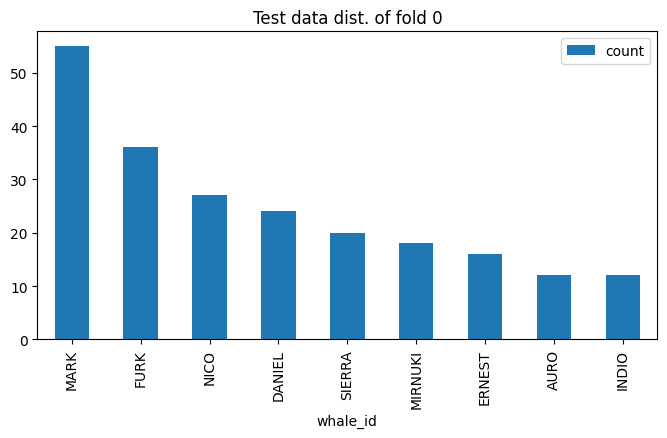

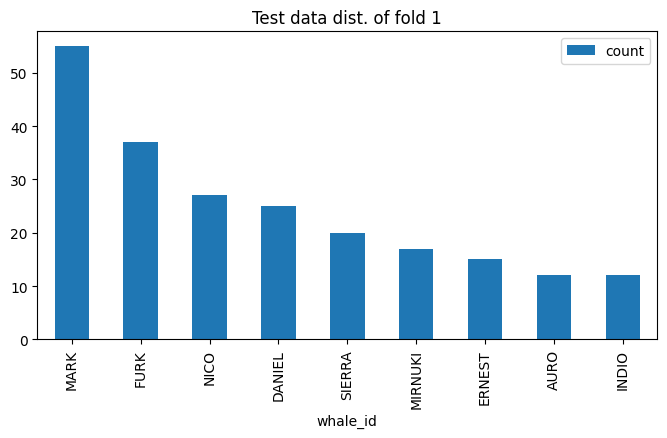

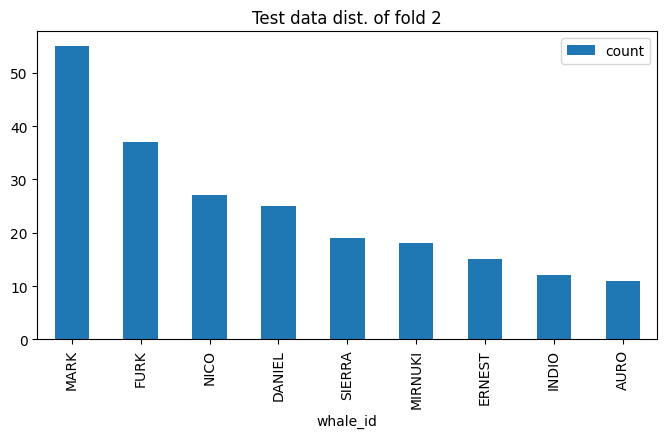

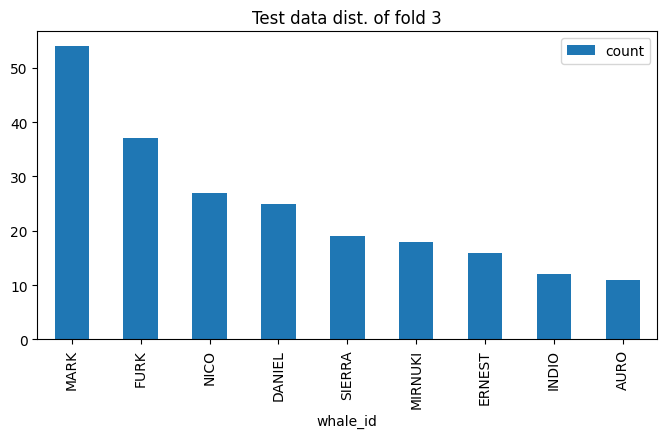

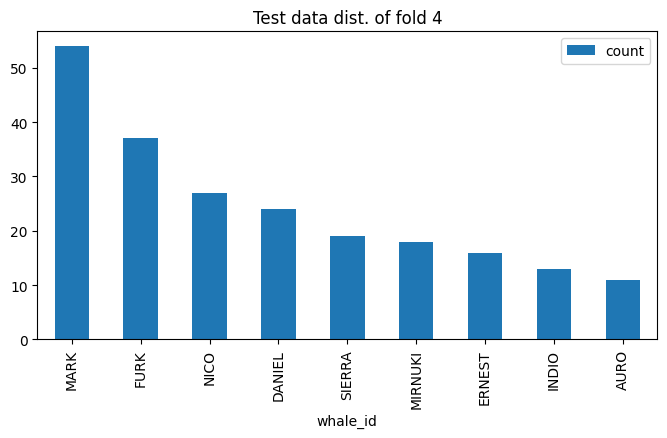

In [ ]:
for i, (train_idx, test_idx) in enumerate(k_fold.split(df_dev, df_dev.label)):

  sub_df = df_dev.iloc[test_idx]
  filtered_count_sub_df = sub_df['whale_id'].value_counts().to_frame()
  filtered_count_sub_df.plot(title=f'Test data dist. of fold {i}', kind='bar', figsize=(8,4))


#### Training loop

0it [00:00, ?it/s]

Starting training fold k=0
Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.8196 - accuracy: 0.4078

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 23s 467ms/step - loss: 1.8196 - accuracy: 0.4078 - val_loss: 1.2658 - val_accuracy: 0.6591
Epoch 2/10
20/20 [==============================] - 8s 429ms/step - loss: 1.0804 - accuracy: 0.7266 - val_loss: 0.8455 - val_accuracy: 0.7955
Epoch 3/10
20/20 [==============================] - 7s 380ms/step - loss: 0.7924 - accuracy: 0.8062 - val_loss: 0.5620 - val_accuracy: 0.8636
Epoch 4/10
20/20 [==============================] - 7s 377ms/step - loss: 0.5654 - accuracy: 0.8594 - val_loss: 0.4276 - val_accuracy: 0.9045
Epoch 5/10
20/20 [==============================] - 6s 339ms/step - loss: 0.4860 - accuracy: 0.8813 - val_loss: 0.3429 - val_accuracy: 0.9273
Epoch 6/10
20/20 [==============================] - 7s 387ms/step - loss: 0.4205 - accuracy: 0.8984 - val_loss: 0.2921 - val_accuracy: 0.9364
Epoch 7/10
20/20 [==============================] - 7s 370ms/step - loss: 0.3801 - accuracy: 0.9203 - val_loss: 0.2786 - val_accuracy: 0.9409
Epoch 8/10
20/20

1it [03:19, 199.81s/it]

Starting training fold k=1
Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.7683 - accuracy: 0.4078

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 23s 475ms/step - loss: 1.7683 - accuracy: 0.4078 - val_loss: 1.2740 - val_accuracy: 0.6818
Epoch 2/10
20/20 [==============================] - 8s 392ms/step - loss: 1.0912 - accuracy: 0.7078 - val_loss: 0.7792 - val_accuracy: 0.8409
Epoch 3/10
20/20 [==============================] - 8s 425ms/step - loss: 0.7841 - accuracy: 0.8078 - val_loss: 0.5870 - val_accuracy: 0.8773
Epoch 4/10
20/20 [==============================] - 7s 353ms/step - loss: 0.5746 - accuracy: 0.8766 - val_loss: 0.4655 - val_accuracy: 0.8955
Epoch 5/10
20/20 [==============================] - 8s 417ms/step - loss: 0.4856 - accuracy: 0.8813 - val_loss: 0.3991 - val_accuracy: 0.9000
Epoch 6/10
20/20 [==============================] - 6s 325ms/step - loss: 0.3974 - accuracy: 0.9047 - val_loss: 0.3515 - val_accuracy: 0.9182
Epoch 7/10
20/20 [==============================] - 8s 404ms/step - loss: 0.3285 - accuracy: 0.9234 - val_loss: 0.3415 - val_accuracy: 0.9318
Epoch 8/10
20/20

2it [05:57, 174.79s/it]

Starting training fold k=2
Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.7555 - accuracy: 0.4203

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 25s 507ms/step - loss: 1.7555 - accuracy: 0.4203 - val_loss: 1.1918 - val_accuracy: 0.6119
Epoch 2/10
20/20 [==============================] - 8s 435ms/step - loss: 1.0862 - accuracy: 0.7063 - val_loss: 0.7494 - val_accuracy: 0.8584
Epoch 3/10
20/20 [==============================] - 7s 360ms/step - loss: 0.7777 - accuracy: 0.7891 - val_loss: 0.5237 - val_accuracy: 0.9132
Epoch 4/10
20/20 [==============================] - 8s 413ms/step - loss: 0.5986 - accuracy: 0.8469 - val_loss: 0.4144 - val_accuracy: 0.9269
Epoch 5/10
20/20 [==============================] - 7s 345ms/step - loss: 0.4816 - accuracy: 0.8750 - val_loss: 0.3250 - val_accuracy: 0.9406
Epoch 6/10
20/20 [==============================] - 8s 410ms/step - loss: 0.4076 - accuracy: 0.9047 - val_loss: 0.2824 - val_accuracy: 0.9452
Epoch 7/10
20/20 [==============================] - 6s 330ms/step - loss: 0.3649 - accuracy: 0.9172 - val_loss: 0.2495 - val_accuracy: 0.9498
Epoch 8/10
20/20

3it [08:37, 168.13s/it]

Starting training fold k=3
Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.7705 - accuracy: 0.4125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 26s 602ms/step - loss: 1.7705 - accuracy: 0.4125 - val_loss: 1.3143 - val_accuracy: 0.5297
Epoch 2/10
20/20 [==============================] - 8s 428ms/step - loss: 1.1030 - accuracy: 0.6906 - val_loss: 0.7748 - val_accuracy: 0.8539
Epoch 3/10
20/20 [==============================] - 7s 384ms/step - loss: 0.7551 - accuracy: 0.8094 - val_loss: 0.5374 - val_accuracy: 0.8950
Epoch 4/10
20/20 [==============================] - 8s 406ms/step - loss: 0.6230 - accuracy: 0.8469 - val_loss: 0.4227 - val_accuracy: 0.9041
Epoch 5/10
20/20 [==============================] - 5s 250ms/step - loss: 0.5028 - accuracy: 0.8797 - val_loss: 0.3531 - val_accuracy: 0.9041
Epoch 6/10
20/20 [==============================] - 9s 478ms/step - loss: 0.4091 - accuracy: 0.8938 - val_loss: 0.2909 - val_accuracy: 0.9361
Epoch 7/10
20/20 [==============================] - 6s 337ms/step - loss: 0.3720 - accuracy: 0.8922 - val_loss: 0.2555 - val_accuracy: 0.9452
Epoch 8/10
20/20

4it [12:18, 189.25s/it]

Starting training fold k=4
Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.7615 - accuracy: 0.4109

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 24s 511ms/step - loss: 1.7615 - accuracy: 0.4109 - val_loss: 1.2998 - val_accuracy: 0.5251
Epoch 2/10
20/20 [==============================] - 7s 378ms/step - loss: 1.0349 - accuracy: 0.7156 - val_loss: 0.7971 - val_accuracy: 0.8037
Epoch 3/10
20/20 [==============================] - 7s 381ms/step - loss: 0.7644 - accuracy: 0.8125 - val_loss: 0.5661 - val_accuracy: 0.8767
Epoch 4/10
20/20 [==============================] - 7s 391ms/step - loss: 0.5787 - accuracy: 0.8609 - val_loss: 0.4345 - val_accuracy: 0.8904
Epoch 5/10
20/20 [==============================] - 6s 331ms/step - loss: 0.4561 - accuracy: 0.8922 - val_loss: 0.3642 - val_accuracy: 0.8904
Epoch 6/10
20/20 [==============================] - 9s 451ms/step - loss: 0.3810 - accuracy: 0.9141 - val_loss: 0.3080 - val_accuracy: 0.9406
Epoch 7/10
20/20 [==============================] - 7s 347ms/step - loss: 0.3394 - accuracy: 0.9156 - val_loss: 0.2644 - val_accuracy: 0.9498
Epoch 8/10
20/20

5it [14:58, 179.66s/it]




---------------------------
Average performance
---------------------------
Accuracy: 0.9562432544624325 +- 0.007392786355341488
F1-score: 0.9460652412513486 +- 0.007691313297388247
Prototypical Accuracy: 0.7855714285714286 +- 0.04547577240907206
Prototypical F1-score: 0.7384158230123692 +- 0.026412395929137484


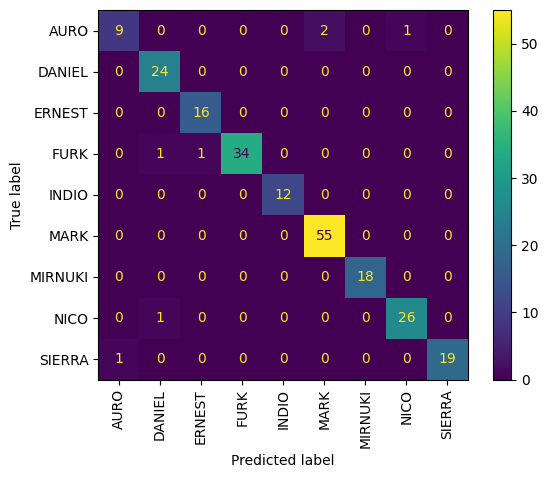

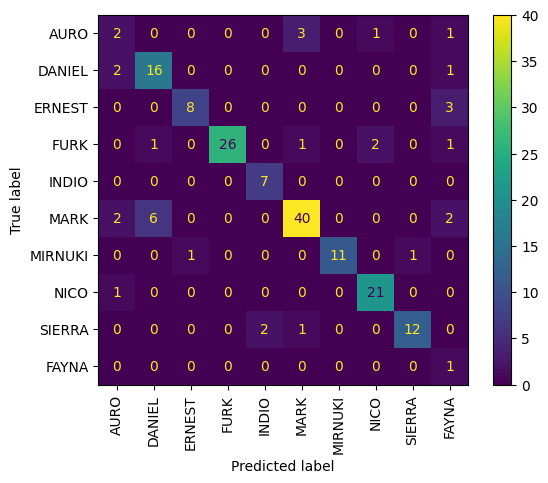

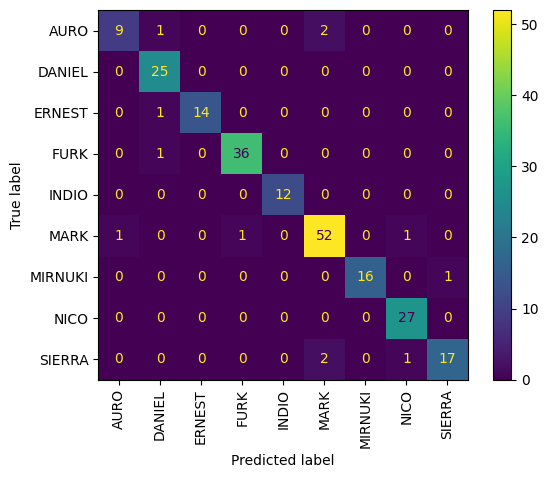

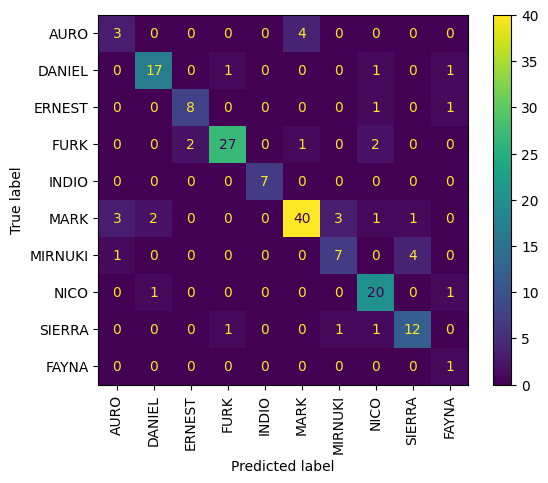

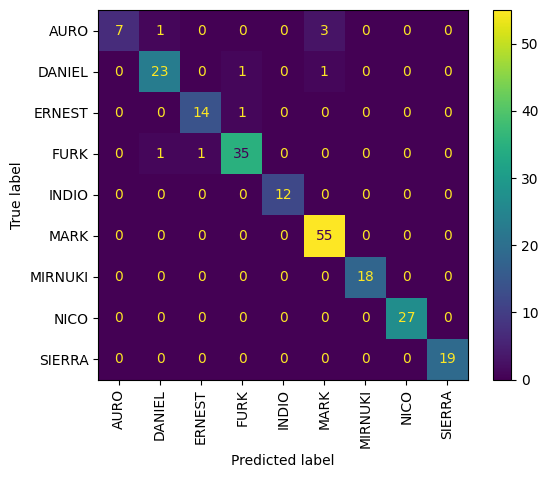

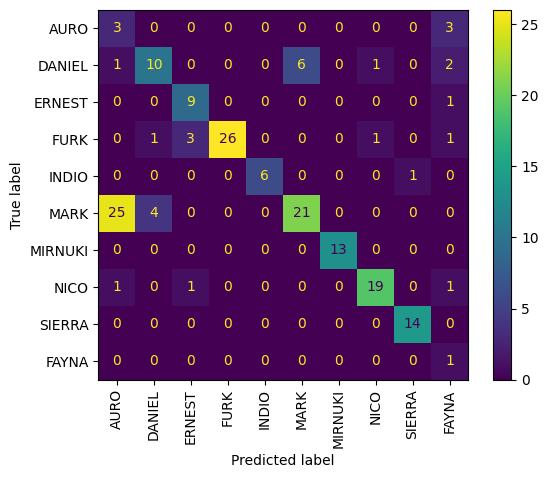

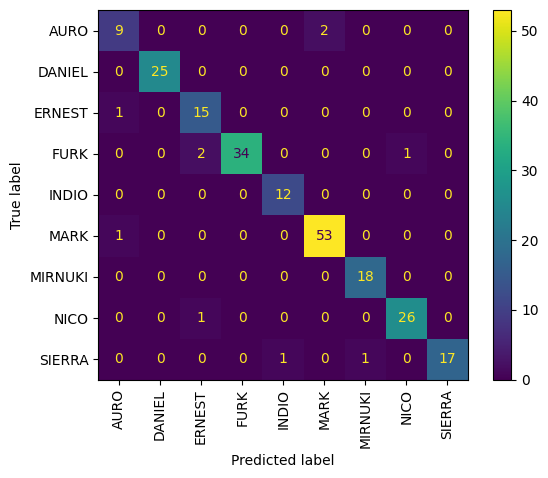

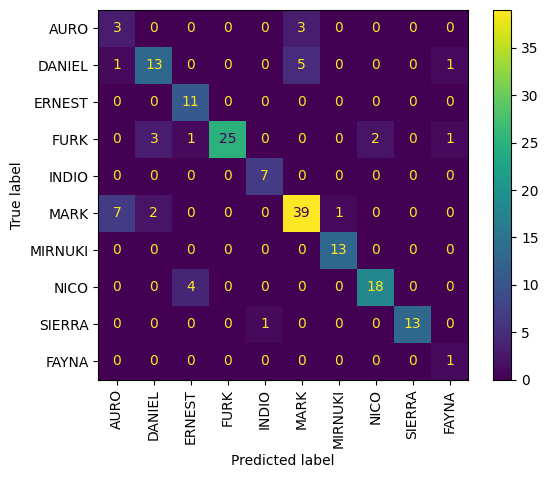

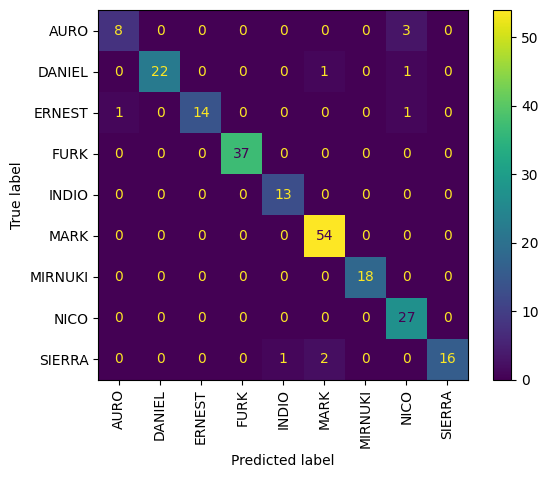

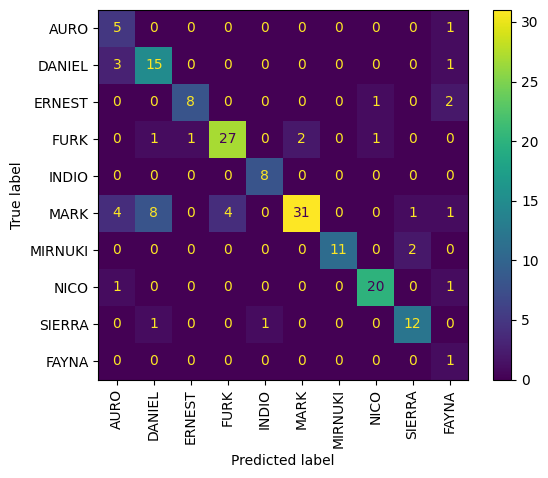

In [ ]:
# Start training
for i, (train_idx, test_idx) in tqdm(enumerate(k_fold.split(df_dev, df_dev.label))):

  print(f"Starting training fold k={i}")

  # Create train ds
  train_df = df_dev.iloc[train_idx]
  train_ds = tf.data.Dataset.from_tensor_slices((train_df['images'], train_df['label']))
  train_ds = data_loader(train_ds, batch_size=TRAIN_BATCH_SIZE)

  # Create val ds
  validation_df = df_dev.iloc[test_idx]
  validation_ds = tf.data.Dataset.from_tensor_slices((validation_df['images'], validation_df['label']))
  validation_ds = data_loader(validation_ds, batch_size=len(test_idx), is_test=True)

  # Initalize model
  model = create_efficient_net()

  folder_name = '/content/drive/MyDrive/Centinela_project/results/'+MODEL_NAME
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)
  elif i == 0:
      print(f"\n\n-------------------\nERROR!: FOLDER {MODEL_NAME} ALREADY EXISTS IN THE PATH. HALTING TRAINING....\n-------------------")
      break

  folder_name_fold = os.path.join(folder_name,f'Fold_{i}')
  os.makedirs(folder_name_fold)

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(folder_name_fold,'saved_model.h5'), monitor='val_accuracy', mode='max', save_best_only=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(
      optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
  )

  # Start training fold
  history = model.fit(train_ds,
          validation_data = validation_ds,
          #class_weight = weight_dict,
          steps_per_epoch = 20,
          validation_steps = 1,
          epochs= 10,
          callbacks=[model_checkpoint_callback]
          )

  evaluate_best_model(model_path=os.path.join(folder_name_fold,'saved_model.h5'), test_set=validation_ds, dest_folder=folder_name_fold)

  prototypical_classification_test(model_path=os.path.join(folder_name_fold,'saved_model.h5'), test_set=validation_ds, k_shot=5, dest_folder=folder_name_fold)

compute_avg_performance(results_folder='/content/drive/MyDrive/Centinela_project/results/'+MODEL_NAME)
